# Text-to-Image Retrieval之LGAM

## LGAM: A Local and Global  Attention Matching For Text-to-Image Retrieval

Text-to-Image Retrieval 意旨通过一个文本描述查询指定数据集中对应的图片，属于跨模态中Image-Text Matching的一项子任务。我们一般将其分为Fast和Slow两种（个人习惯叫法），其中Fast模型就是通过视觉网络提取图片特种，语言网络提取文字特征，然后通过内积或者余弦相似度的方式进行语义的对齐，即Matching。而Slow模型则是兴起于Transformer爆火以后，越来越多的模型将其架构引入相应领域，而多模态就是其中一种。作为多模态重要分支的Matching则也显然受益，本任务则是Matching的一种典型下游任务：Text-to-Image Retrieval，通过先对齐文本与图像的语义特征，然后对于查询语句Query找到数据集中与之最匹配的图片，其评价指标为相应图片在所有数据集中相似度的降序排名，常用Recall_1，Recall_5及Recall_10。而本方法LGAM便是属于Slow模型的一种，通过例如object的细粒度信息进行图文语义匹配。

## 模型简介：

![MO661@FZ%5D%608%5BI0EYFC0NUJO.png](sources/image/1.png)
可以看到，我们的模型主要基于ResNet网络提取图片特征，然后通过Text transformer（这里用的Bert）进行细粒度信息匹配。
以往的方法要么通过视觉网络和NLP网络提取特征后直接通过余弦相似度匹配，要么再结合图文Objects匹配，
但是大多忽略了一个很重要的信息，Objects之间的关系。只有少数的用场景图匹配的方法会关注Objects之间的关系，
例如LGSGM或SRFM。但通过场景图进行匹配也会有一个严重限制，即只考虑图片中是否有这种关系，
但无法真正对齐Relations以及其对应Objects。

![2RDLF%60%29OF$8GS6M3XZLY%7DC0.jpg](sources/image/2.jpg)
方法主要创新：
(1) 提供Subject-Relation-Object三元组的匹配方式；
(2) 通过Attention网络直接对齐图片，文本描述，物体，关系，以及关系三元组。
如下图：

可以看到我们提取出了文本的物体，关系词，以及关系三元组以供网络输入。


## 数据准备

我们选取了TextCaps-OCR数据集中的1000张图片，5000个captions当训练集，100张图片，500个captions当测试集。

数据描述：
我们选取了一些适合做Text Image Retrieval的图文选取得到新的数据集。其中数据集中文本读取格式为字典形式：
'id':{'captions':\[5个句子\]，'obj':\[...\], 'relations':\[...\], 'triplet':\[...\] }

具体如下所示：

```json
 "caef3d1e97c2cf15": {
        "captions": [
            "A book about CEOs is sitting on top of a box.",
            "a book called CEO (Customer Engagement Officer) by Mark Hillary.",
            "A book titled CEO (Customer Engagement Officer) on top of a cardboard box.",
            "A book by Mark Hillary titled CEO sits on top of a box",
            "a book labeled CEO(cusotmer engagement officer) by mark hillary"
        ],
        "obj": [["ceos","book","box"],
             ["book","customer","officer","mark","hillary","engagement","ceo"],
             ["book","customer","officer","engagement","box","ceo","cardboard"],
             ["book","hillary","mark","box","ceo"],
             ["book","officer","mark","hillary","engagement","ceo","cusotmer"]],
        "relations": [["sitting","about"],["called"],["titled"],["titled","by","sits"],["labeled"]],
        "triplet": [
            {"sng": [["book","about","CEOs"]],"stanford": [["book","is sitting on","box"]]},
            {"sng": [],"stanford": []},
            {"sng": [],"stanford": []},
            {"sng": [["book","by","Mark Hillary"],["book","titled","CEO"]],"stanford": [["book","sits on","box"]]},
            {"sng": [],"stanford": [[ "book","labeled","CEO"],["book","labeled","cusotmer engagement officer"],["book","labeled CEO by","mark hillary"]]}
        ]
    },
```

![caef3d1e97c2cf15.jpg](sources/image/3.jpg)

数据集中图片有彩色也有黑白图片，所以需要注意通道转化。
我们这里的数据读取方法为将图片输入ResNet50后将输出维度设置为768\*16维的向量，切分为16个768维度的向量作为Bert的词token输入，
即类似ViT，然后文本将Captions中sentence与对应obj，relations以及triplet进行连接，编码embedding后与图片的16个token进行concat
然后首部加上CLS_token一同输入到Bert中


## 模块

### 修改后的BertModel

融合模型，包含ResNet50网络提取图片特征，并与word_embedding拼接输入到Bert的Encoder中，得到最后一层的信息进行池化。


In [19]:
import mindspore.nn as nn

In [20]:
class BertModel(nn.Cell):
    def __init__(self,
                 config,
                 is_training,
                 use_one_hot_embeddings=False,
                 bs=8
                 ):
        super(BertModel, self).__init__()
        config = copy.deepcopy(config)
        self.bs = bs
        if not is_training:
            config.hidden_dropout_prob = 0.0
            config.attention_probs_dropout_prob = 0.0

        self.hidden_size = config.hidden_size
        self.num_hidden_layers = config.num_hidden_layers
        self.embedding_size = config.hidden_size
        self.token_type_ids = None

        self.last_idx = self.num_hidden_layers - 1
        output_embedding_shape = [-1, config.seq_length, self.embedding_size]

        self.bert_embedding_lookup = nn.Embedding(
            vocab_size=config.vocab_size,
            embedding_size=self.embedding_size,
            use_one_hot=use_one_hot_embeddings,
            embedding_table=TruncatedNormal(config.initializer_range))

        self.bert_embedding_postprocessor = EmbeddingPostprocessor(
            embedding_size=self.embedding_size,
            embedding_shape=output_embedding_shape,
            use_relative_positions=config.use_relative_positions,
            use_token_type=True,
            token_type_vocab_size=config.type_vocab_size,
            use_one_hot_embeddings=use_one_hot_embeddings,
            initializer_range=0.02,
            max_position_embeddings=config.max_position_embeddings,
            dropout_prob=config.hidden_dropout_prob)

        self.bert_encoder = BertTransformer(
            hidden_size=self.hidden_size,
            num_attention_heads=config.num_attention_heads,
            num_hidden_layers=self.num_hidden_layers,
            intermediate_size=config.intermediate_size,
            attention_probs_dropout_prob=config.attention_probs_dropout_prob,
            use_one_hot_embeddings=use_one_hot_embeddings,
            initializer_range=config.initializer_range,
            hidden_dropout_prob=config.hidden_dropout_prob,
            use_relative_positions=config.use_relative_positions,
            hidden_act=config.hidden_act,
            compute_type=config.compute_type,
            return_all_encoders=True)

        self.cast = P.Cast()
        self.dtype = config.dtype
        self.cast_compute_type = SaturateCast(dst_type=config.compute_type)
        self.slice = P.StridedSlice()

        self.squeeze_1 = P.Squeeze(axis=1)
        self.dense = nn.Dense(self.hidden_size, self.hidden_size,
                              activation="tanh",
                              weight_init=TruncatedNormal(config.initializer_range)).to_float(config.compute_type)
        self._create_attention_mask_from_input_mask = CreateAttentionMaskFromInputMask(config)
        self.vision = resnet50(self.embedding_size * 16)  # 使用ResNet50进行图像特征提取
        self.concat = mindspore.ops.Concat(axis=1)  # 定义concat函数进行特征以及mask的拼接

    def construct(self, input_ids, input_mask, frame, frame_mask):
        """Bidirectional Encoder Representations from Transformers."""
        # embedding
        embedding_tables = self.bert_embedding_lookup.embedding_table
        word_embeddings = self.bert_embedding_lookup(input_ids)
        vision_embeddings = self.vision(frame)
        vision_embeddings = vision_embeddings.view((self.bs, 16, -1))
        embed = self.concat((vision_embeddings, word_embeddings))

        frame_mask = frame_mask.repeat(16).view((self.bs, 16))
        mask = self.concat((frame_mask, input_mask))
        attention_mask = self._create_attention_mask_from_input_mask(mask)

        # bert encoder
        encoder_output = self.bert_encoder(self.cast_compute_type(embed),
                                           attention_mask)

        sequence_output = self.cast(encoder_output[self.last_idx], self.dtype)

        # pooler
        batch_size = P.Shape()(input_ids)[0]
        sequence_slice = self.slice(sequence_output,
                                    (0, 0, 0),
                                    (batch_size, 1, self.hidden_size),
                                    (1, 1, 1))
        first_token = self.squeeze_1(sequence_slice)
        pooled_output = self.dense(first_token)
        pooled_output = self.cast(pooled_output, self.dtype)

        return sequence_output, pooled_output, embedding_tables

### 数据读取模块

从本地文件中读取文本数据以及图像数据


In [21]:
class MyDataset:
    def __init__(self, data_path, txt_name, train=True):
        self.tokenizer = FullTokenizer('vocab_2.txt')
        with open(os.path.join(data_path, txt_name), 'r') as f:
            self.data_dict = json.load(f)
        self.new_loader = []
        times = 0
        for i in self.data_dict.keys():
            img = Image.open(os.path.join(data_path, "train" if train else "test", i + '.jpg')).resize((512, 512),
                                                                                                       Image.ANTIALIAS)
            if np.shape(img)[-1] != 3:
                img = img.convert('RGB')
            img = np.array(img)
            img = np.transpose(img, (2, 0, 1))
            assert np.shape(img)[0] == 3, "3 channels image required."
            # patches_number = 16
            # assert np.abs(np.sqrt(patches_number) - int(np.sqrt(patches_number))) <= 1e-8, 'patches_number have to be sqrtable.'
            # patches_dim = int(np.sqrt(patches_number))
            # patches = []
            # wide = np.shape(img)[0] // patches_dim
            # high = np.shape(img)[1] // patches_dim
            # for h in range(patches_dim):
            #     for l in range(patches_dim):
            #         patches.append(img[h * wide:(h + 1) * wide, l * high:(l + 1) * high])
            #         pass
            #     pass
            for j in range(5):  # 5 captions
                triplet = ''
                for p in self.data_dict[i]['triplet'][j]['sng']:
                    triplet += " ".join(p)
                    triplet += "."
                self.new_loader.append([img] + [
                    self.data_dict[i]['captions'][j] + " ".join(self.data_dict[i]['obj'][j]) + "." + " ".join(
                        self.data_dict[i]['relations'][j]) + "." + triplet] + [1])
            ## 创建负样本
            if train:
                random_id = random.choice(list(self.data_dict.keys()))
                if random_id != i:
                    for m in range(5):
                        triplet = ''
                        for p in self.data_dict[random_id]['triplet'][m]['sng']:
                            triplet += " ".join(p)
                            triplet += "."
                        self.new_loader.append(
                            [img] +
                            [self.data_dict[random_id]['captions'][m] +
                             " ".join(self.data_dict[random_id]['obj'][m]) +
                             "." + " ".join(self.data_dict[random_id]['relations'][m]) +
                             "." + triplet] + [0])
            times += 1
            if times == 1000:
                break
        ## EVAL
        # counts = 0
        # self.val_loader = []
        # for i in self.new_loader:
        #     for j in range(100):
        #         if counts == j:
        #             self.val_loader.append([self.new_loader[5 * j][0]] + [i[1]] + [1])
        #             pass
        #         else:
        #             self.val_loader.append([self.new_loader[5 * j][0]] + [i[1]] + [0])
        #             pass
        #         pass
        #     counts += 1
        # self.new_loader = copy.deepcopy(self.val_loader)

    def __len__(self):
        return len(self.new_loader)

    def __getitem__(self, item):
        frame = self.new_loader[item][0]
        frame_mask = np.ones((1,))
        # if len(self.new_loader[item][1]) >= 112:
        #     text = self.new_loader[item][1][:112]
        #     pass
        # else:
        #     text = self.new_loader[item][1] + " " * (112 - len(self.new_loader[item][1]))
        #     pass
        # assert len(text) == 112, "Text Length ERROR."
        token = self.tokenizer.tokenize(self.new_loader[item][1])
        text_mask = np.zeros((112,))
        text_mask[:np.shape(token)[0]] = 1
        text = token[:112]
        Data = namedtuple('data', ['input_ids', 'input_mask', 'frame', 'frame_mask', 'label_ids'])
        data = Data(
            input_ids=text,
            input_mask=text_mask,
            frame=frame,
            frame_mask=frame_mask,
            label_ids=self.new_loader[item][2]
        )
        return data


### Bert微调模块

针对微调任务设计的模块

In [22]:
class BertFinetuneCell(nn.Cell):
    """
    Especially defined for finetuning where only four inputs tensor are needed.

    Append an optimizer to the training network after that the construct
    function can be called to create the backward graph.

    Different from the builtin loss_scale wrapper cell, we apply grad_clip before the optimization.

    Args:
        network (Cell): The training network. Note that loss function should have been added.
        optimizer (Optimizer): Optimizer for updating the weights.
        scale_update_cell (Cell): Cell to do the loss scale. Default: None.
    """

    def __init__(self, network, optimizer, scale_update_cell=None):

        super(BertFinetuneCell, self).__init__(auto_prefix=False)
        self.network = network
        self.network.set_grad()
        self.weights = optimizer.parameters
        self.optimizer = optimizer
        self.grad = C.GradOperation(get_by_list=True,
                                    sens_param=True)
        self.reducer_flag = False
        self.allreduce = P.AllReduce()
        self.parallel_mode = context.get_auto_parallel_context("parallel_mode")
        if self.parallel_mode in [ParallelMode.DATA_PARALLEL, ParallelMode.HYBRID_PARALLEL]:
            self.reducer_flag = True
        self.grad_reducer = None
        if self.reducer_flag:
            mean = context.get_auto_parallel_context("gradients_mean")
            degree = get_group_size()
            self.grad_reducer = DistributedGradReducer(optimizer.parameters, mean, degree)
        self.is_distributed = (self.parallel_mode != ParallelMode.STAND_ALONE)
        self.cast = P.Cast()
        self.gpu_target = False
        if context.get_context("device_target") == "GPU":
            self.gpu_target = True
            self.float_status = P.FloatStatus()
            self.addn = P.AddN()
            self.reshape = P.Reshape()
        else:
            self.alloc_status = P.NPUAllocFloatStatus()
            self.get_status = P.NPUGetFloatStatus()
            self.clear_status = P.NPUClearFloatStatus()
        self.reduce_sum = P.ReduceSum(keep_dims=False)
        self.base = Tensor(1, mstype.float32)
        self.less_equal = P.LessEqual()
        self.hyper_map = C.HyperMap()
        self.loss_scale = None
        self.loss_scaling_manager = scale_update_cell
        if scale_update_cell:
            self.loss_scale = Parameter(Tensor(scale_update_cell.get_loss_scale(), dtype=mstype.float32))

    def construct(self, input_ids, input_mask, frame, frame_mask, label_ids, sens=None):
        """Bert Finetune"""

        weights = self.weights
        init = False
        loss = self.network(input_ids, input_mask, frame, frame_mask, label_ids)
        if sens is None:
            scaling_sens = self.loss_scale
        else:
            scaling_sens = sens

        if not self.gpu_target:
            init = self.alloc_status()
            init = F.depend(init, loss)
            clear_status = self.clear_status(init)
            scaling_sens = F.depend(scaling_sens, clear_status)
        grads = self.grad(self.network, weights)(input_ids, input_mask, frame, frame_mask, label_ids,
                                                 self.cast(scaling_sens,
                                                           mstype.float32))
        grads = self.hyper_map(F.partial(grad_scale, scaling_sens), grads)
        grads = self.hyper_map(F.partial(clip_grad, GRADIENT_CLIP_TYPE, GRADIENT_CLIP_VALUE), grads)
        if self.reducer_flag:
            grads = self.grad_reducer(grads)
        if not self.gpu_target:
            init = F.depend(init, grads)
            get_status = self.get_status(init)
            init = F.depend(init, get_status)
            flag_sum = self.reduce_sum(init, (0,))
        else:
            flag_sum = self.hyper_map(F.partial(_grad_overflow), grads)
            flag_sum = self.addn(flag_sum)
            flag_sum = self.reshape(flag_sum, (()))
        if self.is_distributed:
            flag_reduce = self.allreduce(flag_sum)
            cond = self.less_equal(self.base, flag_reduce)
        else:
            cond = self.less_equal(self.base, flag_sum)
        overflow = cond
        if sens is None:
            overflow = self.loss_scaling_manager(self.loss_scale, cond)
        if not overflow:
            self.optimizer(grads)
        return (loss, cond)


## 训练

训练前需要对代码进行如下改动

### src/dataset.py

- 176行：将train改为True
- 230~242行：注释掉
- 269行：`dataset_gen = MyDataset(data_file_path, "captions/train_v2")`

### bash/run_classifier_gpu.sh

- 42行：true
- 43行：false

### src/bert_for_finetune.py

- 177行：注释掉
- 178~187行：取消注释

----

在修改完代码之后，使用bash运行脚本文件，脚本文件中包含了运行时程序所需要的超参数。

In [14]:
import os

In [16]:
r = os.popen('bash scripts/run_classifier_gpu.sh').readlines()

In [17]:
r

['==============================================================================================================\n',
 'Please run the script as: \n',
 'bash scripts/run_classifier_gpu.sh DEVICE_ID\n',
 'DEVICE_ID is optional, default value is zero\n',
 'for example: bash scripts/run_classifier_gpu.sh DEVICE_ID 1\n',
 'assessment_method include: [MCC, Spearman_correlation ,Accuracy]\n',
 '==============================================================================================================\n',
 'start\n',
 '(8, 3, 512, 512)\n',
 'steps_per_epoch 1250\n',
 '======================================================================================================================================================\n',
 'epoch: 0, current epoch percent: 1.000, step: 1250, outputs are (Tensor(shape=[1], dtype=Float32, value= [ 7.25785971e-01]), Tensor(shape=[], dtype=Bool, value= False))\n',
 'epoch time: 911068.047 ms, per step time: 728.854 ms\n',
 'epoch: 1, current epoch percent: 1.000,

## 测试

测试之前需要手动修改如下代码：

### src/dataset.py

- 176行：将train改为False
- 230~242行：取消注释
- 269行：`dataset_gen = MyDataset(data_file_path, "captions/val_v2")`

### bash/run_classifier_gpu.sh

- 42行：false
- 43行：true

### src/bert_for_finetune.py

- 177行：取消注释
- 178~187行：注释掉


## 评价Ranking


In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [5]:
with open('score_norelations.json', 'r', encoding='utf8') as f:
    score1 = json.load(f)
score1 = np.array(score1)

In [6]:
score1.shape

(100, 5, 100)

In [7]:
with open('score_withrelations.json', 'r', encoding='utf8') as f:
    score2 = json.load(f)
score2 = np.array(score1)

In [8]:
score2.shape

(100, 5, 100)

In [9]:
acc = 0
temp = 0
recall_score1 = []
for m in range(10):
    with open('score_norelations.json', 'r', encoding='utf8') as f:
        score1 = json.load(f)
    score1 = np.array(score1)
    for i in range(len(score1)):
        for j in score1[i]:
            temp = j[i]
            j.sort()
            if temp >= j[-m - 1] and temp != 0:
                acc += 1
    recall_1 = acc / (len(score1) * 5)
    acc = 0
    recall_score1.append(recall_1)

In [10]:
recall_score1

[0.208, 0.308, 0.406, 0.464, 0.502, 0.54, 0.58, 0.596, 0.632, 0.652]

In [11]:
acc = 0
temp = 0
recall_score2 = []
for m in range(10):
    with open('score_withrelations.json', 'r', encoding='utf8') as f:
        score2 = json.load(f)
    score2 = np.array(score2)
    for i in range(len(score2)):
        for j in score2[i]:
            temp = j[i]
            j.sort()
            if temp >= j[-1 - m] and temp != 0:
                acc += 1
    recall_2 = acc / (len(score2) * 5)
    acc = 0
    recall_score2.append(recall_2)

In [12]:
recall_score2

[0.402, 0.542, 0.634, 0.682, 0.746, 0.782, 0.804, 0.816, 0.838, 0.846]

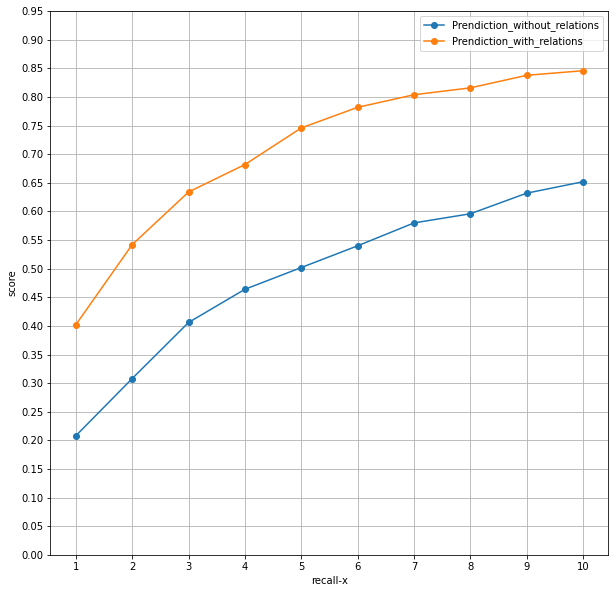

In [13]:
plt.figure(figsize=(10, 10))
x = np.arange(1, 11)

plt.plot(x, recall_score1, '-o', label='Prendiction_without_relations')
plt.plot(x, recall_score2, '-o', label='Prendiction_with_relations')

plt.xlabel("recall-x")
plt.ylabel("score")
plt.xticks(np.arange(1, 11))
plt.yticks(np.arange(0, 1, 0.05))
# plt.text(x,recall_score,"%.0f" % recall_score)
plt.grid()
plt.legend()
plt.show()

## 主要遇到的Bug

### 严重错误

\[CRITICAL\] CORE(28259,7fdd0f261740,python):2022-07-04-07:56:32.042.632 \[mindspore/core/abstract/abstract_value.cc:72\] ShapeJoinLogging\] Shape Join Failed: shape1 = (), shape2 = (8, 1).

这个问题出现在双流模型中，不知道为什么会出现这样的错误，所以也不知道如何去修改

### 在nn.Cell的construct方法中不能使用numpy方法

由于在调试MindSpore的时候出现了未知的错误，因此没有办法进行调试，所以想要在程序运行的过程中使用print方法以及numpy方法查看一些张量的形状，结果出现这样的错误，解决办法就是不使用numpy方法，在construct外查看。

### Tensor不能被切片

这个错误是一个队友在对图片进行操作的时候出现的，代码类似：

```python
from PIL import Image
import numpy as np
import mindspore

im = mindspore.Tensor(np.array(Image.open(path)))
im[0:1]
```

显示`im`无法切片。另外一个队友尝试使用同样方法操作却可以，问了老师也不清楚原因。这一点也是耽误了比较长时间。

### 其他的小错误

这些错误主要是维度不匹配的小错误，原因大多因为对张量的操作不正确，找到出错的地方进行适当修正即可。